# Resume Screening - Applicant Tracking System (ATS)

Henry Yost, Riya Ashok, Angelina Jordan, Gokul Giridharan, and Refugio Zepeda Jr

## Project Outline

[Presentation Link](https://docs.google.com/presentation/d/1MTr2Wf4u3LQDxWHD8F7vfF0gIcAztHeYNlShb_iOBdg/edit?usp=sharing)

**Objective:**

In this project, our objective is to create a resume screening system that helps automate the process of sorting through the resumes and ranking them based on how well they align with a job application in their field. 

**Phase #1 – Filtering**

So first, using the resume.csv file, we are going to classify the 24 job categories into 5-6 buckets and save each file as a csv, so that we can combine certain jobs that tend to have the same broader term, like tech and health. This helps reduce the count from all the resumes in resume.csv into more manageable csv files that will be easier to use. The next step in the process is to find a job description for each bucket/csv file, so that we can compare the job descriptions with the different resume buckets. The next step will be to run RegEx on each of the buckets, which will clean up the text in the resumes by removing punctuation, spaces, special characters, HTML tags, and more. After using RegEx to clean up the data, we can use hard criteria like certain skills needed, and essentially eliminate the resumes that don't fit the hard criteria, which gives us an easier dataset to work with. The next step is to use SBert to turn the text of the resumes and the job descriptions into vectors of fixed size, which allows us to capture the meaning of the text.

**Phase #2 – Ideal Resume Filtering & Human Labeling**

Using the vectors that we got from running SBert, we compute the cosine similarity between the vector of the resume and the vector of the job description. The cosine similarity test will tell us whether or not the resume is what the employer is looking for. In the next phase we are going to pick a couple of the best resumes(3-5) per job description. Then convert each of the best selected resumes into vectors using SBert, and then compute the average of those vectors into a singular vector, which would represent the center of all the resumes for a job category. Then using this centroid, compare all the new resumes to said centroid, using the cosine similarity score. The higher the score = the closer the resume is to the ideal cluster of resumes. We are doing this so that, instead of matching one resume to another we are matching a type of resume to another, which is a much better baseline. Then we look through the top resumes that we are left with and manually decide whether or not the resume is qualified using 1s and 0s and these will become our training label for our supervised learning model. Though this might be a tedious process, we think that it will be very effective in the long run. 

**Phase #3 – Supervised Training**

Next we train a SVM Model from scratch using our own algorithm and we train it using the SBert vectors and the human made labels that we made in the previous step. Then we train a SVM Model using scikit-learn, which is a library, and the input will be the vectors that we made using SBert and human made labels like the last model. Then we will compare the models' outputs using different methods, for example computing their accuracies, precisions, and recalls. Another example would be to make an ROC curve to the performance across all the thresholds. Then to finish it off, we combine the predictions using soft voting, because we are working with limited data, and we are using the same feature space(SBert Vectors) for the two models we are comparing.

## Dataset Exploration & Variables in the Dataset
The main dataset that we are using is Resume.csv from Kaggle, and this dataset contains over 2484 resumes, each labeled with a specific job category. The dataset was approved by the professor, as we are doing a unique project.

* **ID** – The ID is the unique identifier for each resume
* **Resume_str** – The content/words of the resume (including formatting)
* **Resume_html** – The contents of the resume in HTML format
* **Category** – The labeled job field for the respective resume (HR, Tech, Finance, Aviation...)

[Dataset Link](https://www.kaggle.com/datasets/snehaanbhawal/resume-dataset)

### Plan

1. Classify 24 categories into 5-6 meaningful buckets
3. Save each bucket as a new CSV file
4. Find a Job Description (i.e., Software Engineer @ Apple) and use the most closely related CSV file/dataframe (Tech)
5. Preprocess the resumes (lowercasing, removing symbols, indents, etc) using RegEx and Python functions

**Phase 1:** Basic Filtering
1. Use RegEx and hard criteria to filter resumes
2. Convert resumes and job descriptions to SBERT embeddings and compute the  cosine similarity score.

**Phase 2:** Ideal Resume Comparison & Human Labeling
1. Pick multiple IDEAL resumes for the position (let's say the person is leaving, pick multiple ideal resumes for said position)
2. Compute the average embedding and compare new resumes to the centroid of the ideal cluster
3. A human looks through the top resumes and marks them as qualified or not, in addition to considering their similarity to the ideal cluster

**Phase 3:** Supervised Training
1. Train the SVM that we code (we code the architecture) on embeddings
2. Train SVM from the library on the same embeddings
3. Compare outputs
4. Combine via soft voting, rank fusion, or stacking (not sure which one would work best)

## Libraries
For this project, we are using a handful of specific libraries. Please make sure you already have them installed in your conda environment, or run the 'pip install'.

* Pandas, Numpy, 
* Re
* SentenceTransformer
* Numpy

In [7]:
# Installing additional libraries

# This is simply to hide hugging face warnings.
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

!pip install -U -q sentence-transformers
!pip install -q wordcloud
!pip install -q torchvision
!pip install -q hf-xet

In [8]:
# Library Importing
import pandas as pd
import re #RegEx

# First stage resume cleaning
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import math as math
from wordcloud import WordCloud
from collections import Counter
import seaborn as sns

## 1. Importing Dataset & Cleaning

In [10]:
df_orig = pd.read_csv("Data/Resume.csv")
df_orig = df_orig.drop("Resume_html", axis=1) # Drop HTML, because we do not need it

# All possible categories: HR, Designer, Information-Technology, Teacher, Advocate, Business-Development, 
# Healthcare, Fitness, Agriculture, BPO, Sales, Consultant, Digital-Media, Automobile, Chef, 
# Finance, Apparel, Engineering, Accountant, Construction, Public Relations, Banking, Arts, Aviation

# Separate into approx 5 meaningful buckets
df_tech = df_orig[df_orig['Category'].isin(['INFORMATION-TECHNOLOGY', 'ENGINEERING', 'DIGITAL-MEDIA', 'HR'])]
df_tech = df_tech.copy()

df_health_well = df_orig[df_orig['Category'].isin(['HEALTHCARE', 'FITNESS'])]
df_health_well = df_health_well.copy()

df_bus_fin = df_orig[df_orig['Category'].isin(['BUSINESS-DEVELOPMENT', 'SALES', 'CONSULTANT', 'FINANCE', 'ACCOUNTANT', 'BANKING'])]
df_bus_fin = df_bus_fin.copy()

df_creative_public = df_orig[df_orig['Category'].isin(['ARTS', 'DESIGNER', 'PUBLIC-RELATIONS', 'TEACHER', 'ADVOCATE'])]
df_creative_public = df_creative_public.copy()

df_indust = df_orig[df_orig['Category'].isin(['AGRICULTURE', 'AUTOMOBILE', 'CONSTRUCTION', 'AVIATION', 'BPO'])]
df_indust = df_indust.copy()

df_misc = df_orig[df_orig['Category'].isin(['CHEF', 'APPAREL'])]
df_misc = df_misc.copy()

# Write each bucket to a CSV
df_tech.to_csv("Output_csv/tech.csv")
df_health_well.to_csv("Output_csv/health_wellness.csv")
df_bus_fin.to_csv("Output_csv/business_finance.csv")
df_creative_public.to_csv("Output_csv/creative_public.csv")
df_indust.to_csv("Output_csv/industrial.csv")
df_misc.to_csv("Output_csv/miscellaneous.csv")

In [11]:
# Using RegEx to clean the Resume strings
def clean_resume(text):
    text = text.lower() # Make everything lowercase.
    text = re.sub(r'\s+', ' ', text) # replaces whitespace characters with a single space.
    text = re.sub(r'\/+', ' ', text) # replaces / characters with a single space (some resumes use backslashes)
    text = re.sub(r'[^a-z0-9\s\.\,\-]', '', text) # keeps letters, numbers, whitespace, periods, and dashes.
    text = re.sub(r'\s+', ' ', text).strip() # replaces leading and trailing whitespace characters.
    return text

df_tech.loc[:, "Cleaned_str"] = df_tech["Resume_str"].apply(clean_resume)
df_health_well.loc[:, "Cleaned_str"] = df_health_well["Resume_str"].apply(clean_resume)
df_bus_fin.loc[:, "Cleaned_str"] = df_bus_fin["Resume_str"].apply(clean_resume)
df_creative_public.loc[:, "Cleaned_str"] = df_creative_public["Resume_str"].apply(clean_resume)
df_indust.loc[:, "Cleaned_str"] = df_indust["Resume_str"].apply(clean_resume)
df_misc.loc[:, "Cleaned_str"] = df_misc["Resume_str"].apply(clean_resume)

# Also, there are no NaN values, so we don't need to drop any rows.

df_tech.head()

,ID,Resume_str,Category,Cleaned_str
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR,hr administrator marketing associate hr admini...
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...",HR,"hr specialist, us hr operations summary versat..."
2,33176873,HR DIRECTOR Summary Over 2...,HR,hr director summary over 20 years experience i...
3,27018550,HR SPECIALIST Summary Dedica...,HR,"hr specialist summary dedicated, driven, and d..."
4,17812897,HR MANAGER Skill Highlights ...,HR,hr manager skill highlights hr skills hr depar...


## 4. Exploratory Data Analysis (EDA)

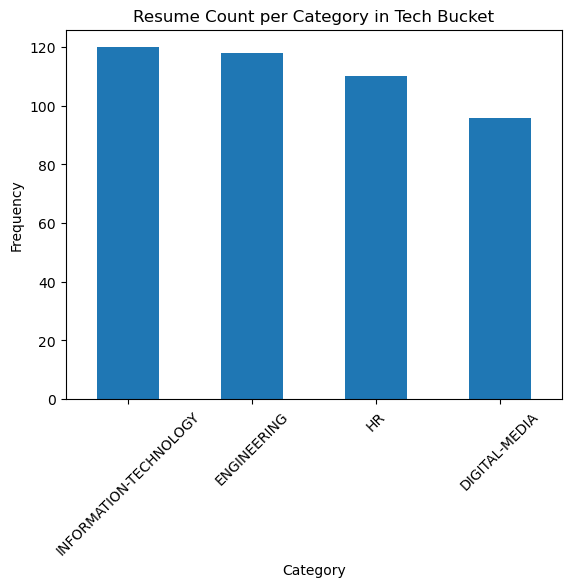

In [13]:
tech_count = df_tech['Category'].value_counts()
tech_count.plot(kind='bar')
plt.title("Resume Count per Category in Tech Bucket")
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

plt.show()

**Analysis:** We can see that our distribution for the resumes is almost equal, and all 4 categories (IT, Engineering, HR, and Digital-Media have over 100 resumes. While this is not a particularly useful EDA for unsupervised or supervised learning, it helps us visualize the distribution of tech resumes in the dataset.

Index(['ID', 'Resume_str', 'Category', 'Cleaned_str'], dtype='object')
Index(['ID', 'Resume_str', 'Category', 'Cleaned_str'], dtype='object')
Index(['ID', 'Resume_str', 'Category', 'Cleaned_str'], dtype='object')


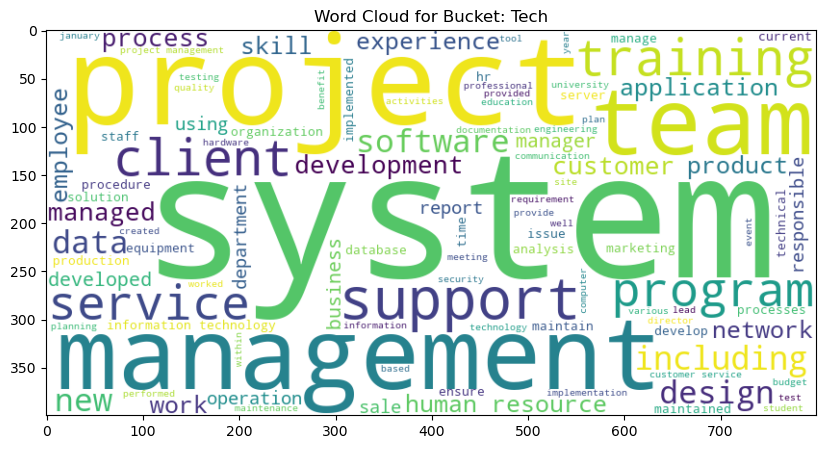

In [15]:
from collections import Counter
print(df_tech.columns)
print(df_bus_fin.columns)
print(df_health_well.columns)

texts = ' '.join(df_tech["Cleaned_str"].astype(str))

custom_stopwords = {'name', 'city', 'state', 'company', 'employee', 'skill'}
words = texts.split()

filtered_words = [word for word in words if word not in custom_stopwords]
filtered_text = ' '.join(filtered_words)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=100
).generate(filtered_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(f"Word Cloud for Bucket: Tech")
plt.show()

**Analysis:** The graph above is a Word Cloud graph of the tech bucket resumes in the dataset, higlihgitng domain-specific terms that are common across each tech resume. The larger the word, the more frequent amongst the resumes. Thus, high frequency terms such as: project, system, software, development, application, data, network are all indicative of the technical knowledge and requirements that are common in the datasets tech resumes. Additionally, we see a lot of high-frequency terms that are indicative of collaborative and/or leadership roles, such as: support, managment, managed, and team. This EDA relates to our project, and specifically the supervised aspect, because the supervised model will be trained on SBERT text embeddings, which are then classified.

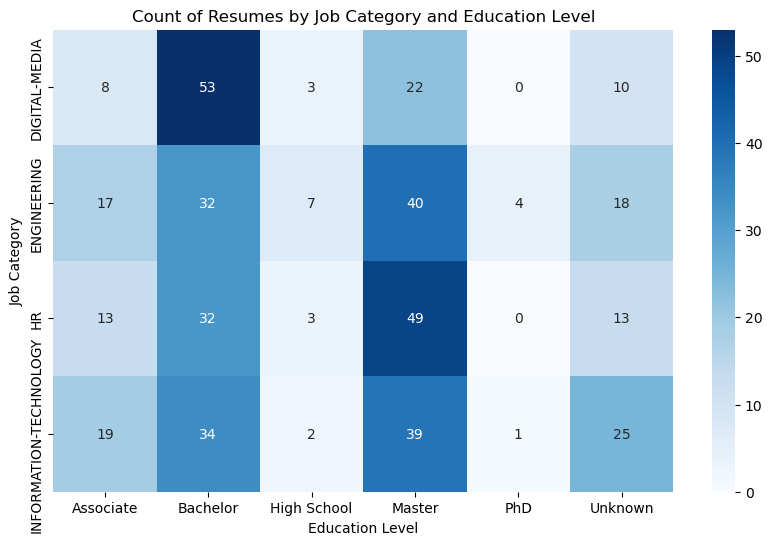

In [17]:
#library
education_levels = {
    'PhD': ['phd', 'doctor of philosophy'],
    'Master': ['master', 'masters', 'msc', 'mba'],
    'Bachelor': ['bachelor', 'bachelors', 'bsc', 'ba'],
    'Associate': ['associate', 'associates'],
    'High School': ['high school', 'ged']
}


def extract_education_level(texts):
    texts = texts.lower()
    for level, keywords in education_levels.items():
        for keyword in keywords:
            if re.search(r'\b' + re.escape(keyword) + r'\b', texts):
                return level
    return 'Unknown'

#Apply the function onto resume string to create a new row 
df_tech['education_level'] = df_tech['Resume_str'].apply(extract_education_level)

heatmap_data = pd.crosstab(df_tech['Category'], df_tech['education_level'])

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='Blues', fmt='d')
plt.title('Count of Resumes by Job Category and Education Level')
plt.ylabel('Job Category')
plt.xlabel('Education Level')
plt.show()

**Analysis:** This is a heatmap that shows the count of different education levels against the 4 job categories in the tech bucket. This is important because we plan on passing the education level as a feature, and looking at the distribution among the dataset can give us important insight. For example, Engineering and IT have good distribution across all degree types, with Masters being among the highest in both groups. PhD's are rare, especially in HR and Digital Media, which have 0 PhDs. This makes sense because generally, engineering students do not pursue a PhD due to specialization not being typically valued unless the role  specifically demands so.

Interestingly, the Unknown category has a concerning number of resumes. However, I believe that this is due to more experienced individuals in the workforce, who have been in the industry for 15-20+ years, and their experience is more relevant than their education. However, this would be interesting to look into more.

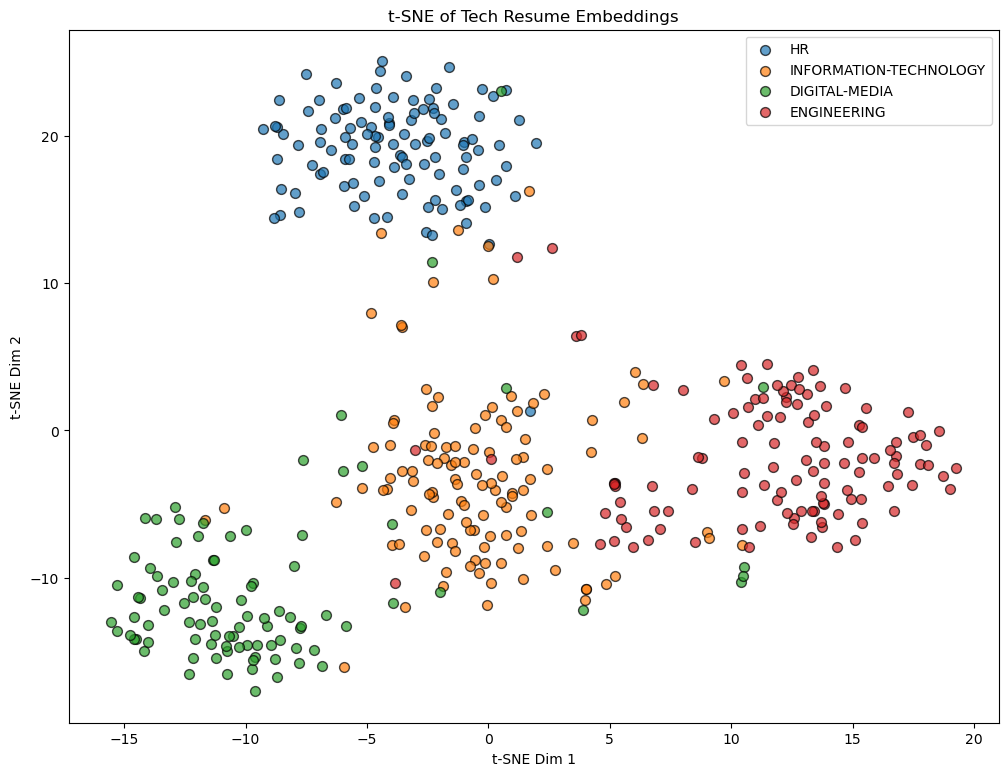

In [19]:
# Graphing resume embeddings with computed similarity
# https://medium.com/analytics-vidhya/visualising-embeddings-with-t-sne-b54bf6b635f\

m_SBERT = SentenceTransformer('all-MiniLM-L6-v2')

resume_embeddings = df_tech['Cleaned_str'].apply(lambda x: m_SBERT.encode(x))
tech_embeddings = np.vstack(resume_embeddings)

# Perplexity is too high, so update it to a number between 5 and 30 based on neighbors
n_samples = tech_embeddings.shape[0]
l_perplexity = min(30, max(2, math.floor(n_samples / 3)))

tsne = TSNE(random_state = 0, max_iter = 1000, metric = 'cosine', perplexity = l_perplexity)
tnse_fitted = tsne.fit_transform(tech_embeddings)

df_tnse_fitted = pd.DataFrame()

# Add Category for plotting, so that we can plot each category with a different color
df_tnse_fitted['Category'] = df_tech['Category']
categories = df_tnse_fitted['Category'].astype('category')
color_codes = categories.cat.codes

df_tnse_fitted['X'] = tnse_fitted[:,0]
df_tnse_fitted['Y'] = tnse_fitted[:,1]

# Plot everything
plt.figure(figsize=(12, 9))

# I had to use ChatGPT for this part because, honestly, I have no idea how to do this and couldn't find a way
# I asked the TA if it was okay during a check-in, and she said it was okay.

# This part basically plots the points, and colors them based on what category they're in, 
# it then also creates a legend for the categories on the plot
unique_categories = df_tnse_fitted['Category'].unique()
colors = plt.cm.tab10.colors

# Loop through each category to plot them one by one
for idx, category in enumerate(unique_categories):
    subset = df_tnse_fitted[df_tnse_fitted['Category'] == category]
    plt.scatter(
        subset['X'], subset['Y'],
        color=colors[idx % len(colors)],
        edgecolors='black',
        label=category,
        s=50,
        alpha=0.7
    )
# Till this part

# Axis labels and title
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.title("t-SNE of Tech Resume Embeddings")
plt.legend()
plt.show()

**t-SNE Visualization of Resume Embeddings:** 
This graph is a visual representation of the flattened SBERT embeddings of the tech resumes. The position of the resumes is based on their embeddings; thus, the closer to each other, the two are more semantically similar. Thus, points clustered around each other mean they have greater semantic similarity.

**Analysis:** As mentioned in the explanation above, the clusters of the SBERT embeddings mean that they are semantically more similar. Thus, it is normal and expected to see the natural clusters that are forming. Each of the categories in the tech bucket (HR, IT, Digital Media, and Engineering) has formed natural clusters because semantically their resumes are similar, and arguably quite distinct from one another. However, interestingly, there are a handful of outliers, and some overlap primarily between IT and Engineering. This is logical because IT and Engineering have overlapping disciplines. Thus, it suggests overlapping language in resumes from both categories, such as common phrases: "project management", "training", "team collaboration", etc, thus it is more difficult to distinguish between the two with SBERT embeddings.

The overlap between IT and Engineering, and the similar overlap in the other categories, poses a risk for the supervised model. The supervised model might misclassify resumes between IT and Engineering. While these categories and resumes may blur in the real world, as mentioned previously, the non-clean decision boundary might make it difficult for the supervised model. However, further cleaning and comparison with the job description and ideal resumes will hopefully remove this ambiguity.

# Tesla Software and Energy Engineer
## Ideal Candidate Resume Selection for Tesla Software and Energy Engineer Role
These resumes were selected as the best matches for the Tesla Software and Energy Engineer position. The Ideal resumes serve as prototypes for the type of candidates Tesla would like to consider if the role became vacant due to an individual leaving, or newly opened. Selection was based on skills, experience, and the overall role alignment. We filtered through the full resume dataset using both strict filtering (education, degree, etc.) and semantic similarity (SBERT embeddings). Resumes were then ranked for their similarity to the job position, and then further evaluated by a group member for their relevance to the position, skills, etc... These two top resumes were selected as the ideal candidates for said position at Tesla.

## Job Position Source
[LinkedIn Tesla Job Application](https://www.linkedin.com/jobs/view/4239183377)

In [22]:
# Here we are simply grabbing the ideal resumes from the dataset, and then removing them so they do not pop up again.
ideal_resume_ID = [82246962, 12472574]

if df_tech['ID'].isin(ideal_resume_ID).any():
    df_ideal = df_tech[df_tech['ID'].isin(ideal_resume_ID)].copy()
    df_tech = df_tech[~df_tech['ID'].isin(ideal_resume_ID)]
df_ideal.head()

,ID,Resume_str,Category,Cleaned_str,education_level
1695,82246962,TEST ENGINEERING Profile I a...,ENGINEERING,test engineering profile i am seeking the chal...,Associate
1802,12472574,QA ENGINEERING TEAM LEAD Care...,ENGINEERING,qa engineering team lead career overview eight...,Unknown


<details>
<summary>  First IDEAL Resume (HTML) (Click to expand) </summary>
<hr>

	Resume_html
1803	<div class="fontsize fontface vmargins hmargins linespacing pagesize" id="document"> <div class="section firstsection" id="SECTION_NAME604878607" style="
      padding-top:0px;
    "> <div class="paragraph PARAGRAPH_NAME firstparagraph" id="PARAGRAPH_604878607_1_393474158" style="
      padding-top:0px;
    "> <div class="name bottomborder" itemprop="name"> <span class="field" id="604878607FNAM1"> </span> <span> </span> <span class="field" id="604878607LNAM1"> QA ENGINEERING TEAM LEAD</span> </div> <div class="lowerborder bottomborder"> </div> </div> </div> <div class="section" id="SECTION_SUMM604878609" style="
      padding-top:0px;
    "> <div class="heading"> <div class="sectiontitle" id="SECTNAME_SUMM604878609"> Career Overview</div> </div> <div class="paragraph firstparagraph" id="PARAGRAPH_604878609_1_393474163" style="
      padding-top:0px;
    "> <div class="field singlecolumn" id="604878609FRFM1"> Eight years of progressive technical experience in quality assurance engineering of computer software in windows environment Strong practical and theoretical knowledge of software quality assurance tools and techniques. Proven ability to develop system test strategy and methodology full-scale system integration and testing for quality, reliability, functionality and computability. Expertise in development of IEEE compliant testing documentation Key contributor to software development teams supporting the release of many new products and release of several major upgrades to existing products Experience in testing large and complex client/server database applications Multi-platform product delivery experience on PC system. Experienced with windows graphical products, networking and/or data acquisition software experienced in manual and automated testing working on projects of a diverse scope able to expertise judgment within defined parameters. Strong knowledge in automated and manual black box testing, including acceptance, functional, regression, stress, compatibility and integration testing techniques, bug reporting and error handling. Responsibilities include review software requirement and functional specification documents, participation in code walk-trough and assist in design and development of test plan and procedures To secure a position that will allow me to exercise skills obtained through education and prior work experiences.</div> </div> </div> <div class="section" id="SECTION_HILT604878610" style="
      padding-top:0px;
    "> <div class="heading"> <div class="sectiontitle" id="SECTNAME_HILT604878610"> Qualifications</div> </div> <div class="paragraph firstparagraph" id="PARAGRAPH_604878610_1_393474164" style="
      padding-top:0px;
    "> <div class="singlecolumn maincolumn"> <table class="twocol"> <tbody> <tr> <td class="field twocol_1" id="604878610SKC11"> <p align="LEFT"> Analytical and Problem Solving </p> <br/> <p align="LEFT"> Stress Tolerance </p> <br/> <p align="LEFT"> Communication Skills </p> <br/> <p align="LEFT"> Leadership Skills </p> <br/> </td> <td class="field twocol_2" id="604878610SKC21"> <ul> <li> Ability to resolve non-routine and complex business issues: Anticipate problems, develop alternate solutions and manage execution successfully </li> <br/> <li> Ability to maintain a high energy level for extended periods of time </li> <br/> <li> Ability to communicate clearly and efficiently both verbally and in writing. Ability to develop and maintain close working relationships with end users, business analysts, documentation specialists, other testers and developers and senior management </li> <br/> <li> Experience in building and leading close-knit teams in a demanding environment with ambiguous or undefined and frequently changing requirements </li> </ul> </td> </tr> </tbody> </table> </div> </div> </div> <div class="section" id="SECTION_TSKL604879014" style="
      padding-top:0px;
    "> </div> <div class="section" id="SECTION_ACCM604879015" style="
      padding-top:0px;
    "> </div> <div class="section" id="SECTION_EXPR604878611" style="
      padding-top:0px;
    "> <div class="heading"> <div class="sectiontitle" id="SECTNAME_EXPR604878611"> Work Experience</div> </div> <div class="paragraph firstparagraph" id="PARAGRAPH_604878611_1_393474165" itemscope="" itemtype="https://schema.org/Organization" style="
      padding-top:0px;
    "> <div class="singlecolumn"> <span class="paddedline"> <span class="companyname" id="604878611COMP1" itemprop="name"> Company Name</span> <span> </span> <span class="datesWrapper"> <span class="jobdates" format="%B %Y" id="604878611JSTD1"> March 2001</span> <span>  to </span> <span class="jobdates" format="%B %Y" id="604878611EDDT1"> July 2001</span> </span> </span> <span class="paddedline" itemscope="" itemtype="https://schema.org/postalAddress"> <span class="jobtitle" id="604878611JTIT1"> QA Engineering Team Lead</span> <br/> <span class="joblocation jobcity" id="604878611JCIT1" itemprop="addressLocality"> City</span> <span> , </span> <span class="joblocation jobstate" id="604878611JSTA1" itemprop="addressRegion"> State</span> </span> <span class="paddedline"> <span class="jobline" id="604878611JDES1" itemprop="description"> Imagicast(TM) is the first end-to-end service that gives today's educated consumers exactly what they want on the retail floor- the rich product information, personalization and access to the unlimited inventory of the Internet combined with the immediate gratification of an in-store purchase. The primary responsibility for the quality of our Imagicast product line, lead the QA team assigned to the Imagicast related quality tasks, established appropriate QA methods, inspections, tests and documentation to verify software quality prior to release in a shipping product. Also, was involved in the diagnosis of product failures or performance problems reported from the field. QA tasks applicable to the product included verifying operation of a DVD playback system, verifying operation of peripheral devices (e.g. keyboard, printer) connected to the embedded system, verifying data collection functions over a wireless data network and verifying presentation of HTML pages on an internet device. Performed QA tests on complex, multi threaded systems and interpreting specifications for product features and designed appropriate test cases. Applied QA processes to reveal functional and performance problems affecting web pages in real time embedded systems. Responsibilities included verifying data warehousing and data mining applications used for business intelligence, e-business server side applications, multi-channel business applications, personalization features, and virtual inventory management applications typically found in a 'clicks and mortar' business</span> </span> </div> </div> <div class="paragraph" id="PARAGRAPH_604878611_2_393474166" itemscope="" itemtype="https://schema.org/Organization" style="
      padding-top:0px;
    "> <div class="singlecolumn"> <span class="paddedline"> <span class="companyname" id="604878611COMP2" itemprop="name"> Company Name</span> <span> </span> <span class="datesWrapper"> <span class="jobdates" format="%B %Y" id="604878611JSTD2"> May 2000</span> <span>  to </span> <span class="jobdates" format="%B %Y" id="604878611EDDT2"> February 2001</span> </span> </span> <span class="paddedline" itemscope="" itemtype="https://schema.org/postalAddress"> <span class="jobtitle" id="604878611JTIT2"> Quality Assurance Engineering Manager</span> <br/> <span class="joblocation jobcity" id="604878611JCIT2" itemprop="addressLocality"> City</span> <span> , </span> <span class="joblocation jobstate" id="604878611JSTA2" itemprop="addressRegion"> State</span> </span> <span class="paddedline"> <span class="jobline" id="604878611JDES2" itemprop="description"> SenticaXchange(TM) is the mobile solution that quickly enables alerts, two-way push and pull transactions and content delivery to all wireless devices as well as landline phones. The Sentica Xchange(TM) approach enables users or applications to initiate communication sessions and complete transactions at any time, interact and transact with their on-the-go subscribers and receive immediate confirmation and response over telephones, cell phones, wireless application protocol (WAP) devices, PDAs (Palm VII, CE devices and Pocket PC) and pagers as well as to build a single implementation for any desired application and enable all text, voice, image and video data to all communications devices. SenticaXchange(TM) System Administration and Management Module functionality provides full access to customer information from each touch-point in the enterprise and to each customer or employees who interact with the customer. These applications provide the breadth of functionality needed to succeed in the competitive wireless business. Primarily responsible for performing analysis of existing job flows, coordination and update of systems documentation, and providing proposals for change where needed and assisting with test execution Performed analysis and Test Document design for different projects within SenticaXchange(TM) including ADT - GUI Tool - Application Development Tool, and Composer API and SAM - System Administration Management, which is an interface for utilizing UNIX and Oracle/SQL, and various network protocols.</span> </span> </div> </div> <div class="paragraph" id="PARAGRAPH_604878611_3_393474167" itemscope="" itemtype="https://schema.org/Organization" style="
      padding-top:0px;
    "> <div class="singlecolumn"> <span class="paddedline"> <span class="companyname" id="604878611COMP3" itemprop="name"> Company Name</span> <span> </span> <span class="datesWrapper"> <span class="jobdates" format="%B %Y" id="604878611JSTD3"> November 1998</span> <span>  to </span> <span class="jobdates" format="%B %Y" id="604878611EDDT3"> May 2000</span> </span> </span> <span class="paddedline" itemscope="" itemtype="https://schema.org/postalAddress"> <span class="jobtitle" id="604878611JTIT3"> QA Lead for Customer Care/Service Applications</span> <br/> <span class="joblocation jobcity" id="604878611JCIT3" itemprop="addressLocality"> City</span> <span> , </span> <span class="joblocation jobstate" id="604878611JSTA3" itemprop="addressRegion"> State</span> </span> <span class="paddedline"> <span class="jobline" id="604878611JDES3" itemprop="description"> Oracle Customer Care/Service Applications - full business process management is provided with functionality in support, scheduling and dispatching spare parts, logistics, service billing and field service as well as in contracts. Rounding out the offering, customer care functionality provides full access to customer information from each touch-point in the enterprise and to each customer care agent or other employees who interact with the customer. These applications provide the breadth of functionality needed to succeed in the competitive support, field service and depot repair business. Full business process management is provided with functionality in support, scheduling and dispatching, spare parts, logistics, and service billing and mobile field service as well as in contracts from the. Rounding out the offering, customer care functionality provides full access to customer information from each touch-point in the enterprise and to each customer care agent or other employees who interact with the customer. Performed analysis and Test Document designfor Oracle Customer Care/Service Applications including Oracle Telephony Management (OTM) system. OTM is a high-volume cross-platform interface engine utilizing UNIX 10.x/C++, Oracle/SQL, and various network protocols. Primarily responsible for performing analysis of existing job flows, coordination and update of systems documentation, and providing proposals for change where needed and assisting with test execution Oracle Maintenance Repair and Overhaul (MRO) and System Resource Planning Modules (SRP) - Performed a high- to medium-level analysis of Maintenance Repair and Overhaul (MRO) and System Resource Planning (SRP) Modules within Oracle Applications. These systems are decentralized and running on various platforms. Primarily responsible for oversight of QA Testing process &amp; deliverables. Provided a detailed recommendation, including complete time and cost estimations, for test processes including direction, management, and oversight of activities involved in defining the related requirements, infrastructure, standards, training, support, methods, and procedures. Also heavily involved in the strategic planning related to corporate-wide Year 2000 certification. Coordinated end-user and systems support staff training. Administered issues management, required escalations, jeopardy notifications, and resolutions. Provided verbal and written status reports to senior-level management on a regular basis. Worked closely with both civil and software engineers to create an easy to use and understand informational product in a NT 4.0 environment Provided change, risk, and implementation management. Held ultimate responsibility for all deliverables, status reports, and final product delivery Designed and developed a QA Test Plan for manual and automated Test Scripts for quality assurance of Windows-based applications and their functionality. Responsibilities included coordination of application support activities, application analysis and testing, as well as operating system support and maintenance. Also assisted with the coordination and delivery of end-user training</span> </span> </div> </div> <div class="paragraph" id="PARAGRAPH_604878611_4_393474168" itemscope="" itemtype="https://schema.org/Organization" style="
      padding-top:0px;
    "> <div class="singlecolumn"> <span class="paddedline"> <span class="companyname" id="604878611COMP4" itemprop="name"> Company Name</span> <span> </span> <span class="datesWrapper"> <span class="jobdates" format="%B %Y" id="604878611JSTD4"> February 1998</span> <span>  to </span> <span class="jobdates" format="%B %Y" id="604878611EDDT4"> November 1998</span> </span> </span> <span class="paddedline" itemscope="" itemtype="https://schema.org/postalAddress"> <span class="jobtitle" id="604878611JTIT4"> Mail - Software Quality Engineer II</span> <br/> <span class="joblocation jobcity" id="604878611JCIT4" itemprop="addressLocality"> City</span> <span> , </span> <span class="joblocation jobstate" id="604878611JSTA4" itemprop="addressRegion"> State</span> </span> <span class="paddedline"> <span class="jobline" id="604878611JDES4" itemprop="description"> As a Quality Assurance Manager my role and responsibility included leading a QA team in black box and white box testing of a distributed architecture system with client and server components and proactively to be involved in the code walk trough and design review meetings to learn about the product and have great understanding of the software developed and be able to execute testing from low-level communications protocols to backend database systems. Lead developing test plans, test cases and regression suites and make sure that test plans are executed and results communicated and developed strategies together with the development and QA team are improving the quality/testability of our components and usability of final products.</span> </span> </div> </div> <div class="paragraph" id="PARAGRAPH_604878611_5_393474169" itemscope="" itemtype="https://schema.org/Organization" style="
      padding-top:0px;
    "> <div class="singlecolumn"> <span class="paddedline"> <span class="companyname" id="604878611COMP5" itemprop="name"> Company Name</span> <span> </span> <span class="datesWrapper"> <span class="jobdates" format="%B %Y" id="604878611JSTD5"> September 1997</span> <span>  to </span> <span class="jobdates" format="%B %Y" id="604878611EDDT5"> February 1998</span> </span> </span> <span class="paddedline" itemscope="" itemtype="https://schema.org/postalAddress"> <span class="jobtitle" id="604878611JTIT5"> Senior Quality Assurance Analyst</span> <br/> <span class="joblocation jobcity" id="604878611JCIT5" itemprop="addressLocality"> City</span> <span> , </span> <span class="joblocation jobstate" id="604878611JSTA5" itemprop="addressRegion"> State</span> </span> <span class="paddedline"> <span class="jobline" id="604878611JDES5" itemprop="description"> Foster City Electronic Invoice Presentment is a new enhancement to Visa e-Pay Service and provides Member Financial Institutions the ability to offer Billers and Retail Customers electronic invoice delivery capability. EIP system is based on Windows NT 4.0 platform and is developed using Visual Basic and Access database as the back end. System performs data transport via the following communication channels: MS Exchange, Virtual Area Network (VAN) LAN, CompuServe and Sprint-Net Responsible for developing of low-level QA Test Plan and QA Reference Documentation and QA Findings Document for the Pilot project. Assist in development of new testing methods and procedures, and improving testing efficiencies. Recommended methods for automating testing using QA Partners a tool Perform Acceptance, functional, GUI usability, and error handling stress and regression testing using black box and gray box testing techniques. Validate that data integrity and security is presented on all levels of data transport: verify transmission completeness against the database, compare input with output using MS-DOS batch file, check files format against the known set of templates, test data encryption and password protection Interviewed new applicants for QA Analyst positions for the project Trained new members of the team for the their first days Assigned responsibilities to the team members and wrote daily status reports, which included summery of the activities performed during each shift, to the Project Lead. Presented QA Group on the Department meetings as a QA Team Lead and conference calls every 4 hours, which included report of the progress in the testing cycle. Made sure that needed support was provided to the QA Team from the Developing Team. Performed manual and automated testing of the application. Entered open/found Drs/bugs into TRACKER bug tracking database and verified that Drs/bugs was close/fixed. Wrote and executed test cases for acceptance, boundary, performance, regression, volume and stress testing. Developed and performed automated test cases using QA Partner 4.0 in Windows NT environment. Wrote "The Findings Document" - a summary document of QA Team analyses, findings, suggestions and/or concerns found during the testing cycle on the project</span> </span> </div> </div> <div class="paragraph" id="PARAGRAPH_604878611_6_393474170" itemscope="" itemtype="https://schema.org/Organization" style="
      padding-top:0px;
    "> <div class="singlecolumn"> <span class="paddedline"> <span class="companyname" id="604878611COMP6" itemprop="name"> Company Name</span> <span> </span> <span class="datesWrapper"> <span class="jobdates" format="%B %Y" id="604878611JSTD6"> March 1993</span> <span>  to </span> <span class="jobdates" format="%B %Y" id="604878611EDDT6"> September 1997</span> </span> </span> <span class="paddedline" itemscope="" itemtype="https://schema.org/postalAddress"> <span class="jobtitle" id="604878611JTIT6"> Software Quality Assurance</span> <br/> <span class="joblocation jobcity" id="604878611JCIT6" itemprop="addressLocality"> City</span> <span> , </span> <span class="joblocation jobstate" id="604878611JSTA6" itemprop="addressRegion"> State</span> </span> <span class="paddedline"> <span class="jobline" id="604878611JDES6" itemprop="description"> Day-Timer Organizer 2.0 for Windows 3.1/3.11 personal manager with advanced features (works with Day-Timer brand name paper of different format).-personal manager with advanced features (works with Day-Timer brand name paper of different format). Test Client/Server Application - database application developed for non-profit organization (Clients, donators, employees, events, etc.). The database was developed in MS Access and MS Visual Basic. It runs under Windows 95. Test functionality of the application creating, modifying and deleting records. Provide regression, acceptance, unit and integration testing. Create and execute cases for regression testing of designating areas of testing. Develop automated test suites utilizing QA Partner 3.5, emphasized testing of the features such as Printing Envelopes and Labels, User Preferences, Startup Screen. Entered bugs into Lotus Notes bug tracking database, verified bugs</span> </span> </div> </div> </div> <div class="section" id="SECTION_EDUC604878612" style="
      padding-top:0px;
    "> <div class="heading"> <div class="sectiontitle" id="SECTNAME_EDUC604878612"> Education and Training</div> </div> <div class="paragraph firstparagraph" id="PARAGRAPH_604878612_1_393474171" itemscope="" itemtype="https://schema.org/EducationalOrganization" style="
      padding-top:0px;
    "> <div class="singlecolumn"> <span class="paddedline"> <span class="companyname companyname_educ" id="604878612SCHO1" itemprop="name"> National Education Center</span> </span> <span class="paddedline" itemprop="description"> <span class="degree" id="604878612DGRE1" itemprop="name"> </span> <span class="programline" id="604878612STUY1"> Management</span> </span> <span class="paddedline"> <span class="joblocation jobcity" id="604878612SCIT1"> City</span> <span> , </span> <span class="joblocation jobstate" id="604878612SSTA1"> State</span> <span> , </span> <span class="joblocation jobstate" id="604878612SCNT1"> US</span> </span> <span class="paddedline"> <span class="field" id="604878612FRFM1"> 08/93-02/94 Management Minor, National Education Center, San Francisco, California</span> </span> </div> </div> <div class="paragraph" id="PARAGRAPH_604878612_2_393474172" itemscope="" itemtype="https://schema.org/EducationalOrganization" style="
      padding-top:0px;
    "> <div class="singlecolumn"> <span class="paddedline"> <span class="companyname companyname_educ" id="604878612SCHO2" itemprop="name"> Kensington Training Program</span> </span> <span class="paddedline" itemprop="description"> <span class="degree" id="604878612DGRE2" itemprop="name"> </span> <span class="programline" id="604878612STUY2"> </span> </span> <span class="paddedline"> <span class="joblocation jobcity" id="604878612SCIT2"> City</span> <span> , </span> <span class="joblocation jobstate" id="604878612SSTA2"> State</span> <span> , </span> <span class="joblocation jobstate" id="604878612SCNT2"> US</span> </span> <span class="paddedline"> <span class="field" id="604878612FRFM2"> 08/93-02/94 Testing Computer Software, Kensington Training Program, San Mateo, California</span> </span> </div> </div> <div class="paragraph" id="PARAGRAPH_604878612_3_393474173" itemscope="" itemtype="https://schema.org/EducationalOrganization" style="
      padding-top:0px;
    "> <div class="singlecolumn"> <span class="paddedline"> <span class="companyname companyname_educ" id="604878612SCHO3" itemprop="name"> Technion University</span> <span> </span> </span> <span class="paddedline" itemprop="description"> <span class="degree" id="604878612DGRE3" itemprop="name"> BS</span> <span> : </span> <span class="programline" id="604878612STUY3"> Electrical Engineering</span> </span> <span class="paddedline"> <span class="joblocation jobcity" id="604878612SCIT3"> City</span> <span> , </span> <span class="joblocation jobstate" id="604878612SSTA3"> </span> <span class="joblocation jobstate" id="604878612SCNT3"> IL</span> </span> <span class="paddedline"> <span class="field" id="604878612FRFM3"> 01/90-05/93 BS Electrical Engineering - Technion University - Haifa, Israel</span> </span> </div> </div> </div> <div class="section" id="SECTION_CERT604878617" style="
      padding-top:0px;
    "> <div class="heading"> <div class="sectiontitle" id="SECTNAME_CERT604878617"> Certifications</div> </div> <div class="paragraph firstparagraph" id="PARAGRAPH_604878617_1_393474174" style="
      padding-top:0px;
    "> <div class="field singlecolumn" id="604878617FRFM1"> National Education Center</div> </div> </div> <div class="section" id="SECTION_AFIL604878613" style="
      padding-top:0px;
    "> <div class="heading"> <div class="sectiontitle" id="SECTNAME_AFIL604878613"> Professional Affiliations</div> </div> <div class="paragraph firstparagraph" id="PARAGRAPH_604878613_1_393474175" style="
      padding-top:0px;
    "> <div class="field singlecolumn" id="604878613FRFM1"> Electronic Invoice Presentment is a new enhancement to Visa e-Pay Service and provides Member Financial Institutions the ability to offer Billers and Retail Customers electronic invoice delivery capability. EIP system is based on Windows NT 4.0 platform and is developed using Visual Basic and Access database as the back end. System performs data transport via the following communication channels: MS Exchange, Virtual Area Network (VAN) LAN, CompuServe and Sprint-Net Responsible for developing of low-level QA Test Plan and QA Reference Documentation and QA Findings Document for the Pilot project. Assist in development of new testing methods and procedures, and improving testing efficiencies. Recommended methods for automating testing using QA Partners a tool Perform Acceptance, functional, GUI usability, and error handling stress and regression testing using black box and gray box testing techniques. Validate that data integrity and security is presented on all levels of data transport: verify transmission completeness against the database, compare input with output using MS-DOS batch file, check files format against the known set of templates, test data encryption and password protection Interviewed new applicants for QA Analyst positions for the project; Trained new members of the team for the their first days; Assigned responsibilities to the team members and wrote daily status reports, which included summery of the activities performed during each shift, to the Project Lead. Presented QA Group on the Department meetings as a QA Team Lead and conference calls every 4 hours, which included report of the progress in the testing cycle. Made sure that needed support was provided to the QA Team from the Developing Team. Performed manual and automated testing of the application. Entered open/found Drs/bugs into TRACKER bug tracking database and verified that Drs/bugs was close/fixed. Wrote and executed test cases for acceptance, boundary, performance, regression, volume and stress testing. Developed and performed automated test cases using QA Partner 4.0 in Windows NT environment. Wrote "The Findings Document" - a summary document of QA Team analyses, findings, suggestions and/or concerns found during the testing cycle on the project</div> </div> </div> <div class="section" id="SECTION_SKLL604878628" style="
      padding-top:0px;
    "> <div class="heading"> <div class="sectiontitle" id="SECTNAME_SKLL604878628"> Skills</div> </div> <div class="paragraph firstparagraph" id="PARAGRAPH_604878628_1_393474179" style="
      padding-top:0px;
    "> <div class="field singlecolumn" id="604878628FRFM1"> Quality Assurance, Testing, Access, Qa, Cases, Database, Regression Testing, Visual Basic, Client/server, Clients, Integration, Integration Testing, Integrator, Lotus Notes, Microsoft Windows, Ms Access, Ms Visual Basic, Printing, Software Quality Assurance, Windows 95, Electrical Engineering, Documentation, Network Protocols, Oracle, Proposals, Sql, Unix, Qa Test, Test Plan, Test Cases, Application Analysis, Application Support, Automated Test Scripts, Basis, Billing, Business Process Management, C++, Contracts, Dispatching, Issues Management, Logistics, Maintenance, Maintenance Repair, Planning Modules, Process Management, Qa Testing, Scheduling, Staff Training, Strategic Planning, Systems Support, Telephony, Test Scripts, Training, Graphical User Interface, Gui, Wireless, Black Box, Usability, Adt, Api, Application Development, Pocket Pc, System Administration, Systems Administration, Telephones, Voice, Wap, Retail, Retail Marketing, Team Lead, Architecture, Database Systems, Design Review, Engineer, Quality Engineer, Software Quality Engineer, Test Plans, White Box, White Box Testing, Black Box Testing, Data Acquisition, Databases, Db2, Dbase, Dbase Iv, Excellent Verbal And Written Communication Skills, Ftp, Ieee, Internet Explorer, Ipx, Java, Javascript, Linux, Ms Office, Netbeui, Netscape, Networking, New Products, Novell, Operations, Problem Solving, Rdbms, San, Software Development, Software Testing, Solutions, Storage Area Network, Structured Software, System Integration, Tcp, Tcp/ip, Virtual Machine, Visual Test, Vm, Assurance Analyst, Automated Testing, Back End, Data Integrity, Dos, Encryption, Exchange, File, Invoice, Lan, Ms Exchange, Ms-dos, Progress, Security, Business Intelligence, Collection, Data Collection, Data Mining, Data Warehousing, E-business, Embedded Systems, Html, Inspections, Inventory, Qa Engineering, Real Time, Real Time Embedded, Real Time Embedded Systems, Shipping, Wireless Data</div> </div> </div> </div>

<hr>
</details>

<details>
<summary> Second IDEAL Resume (HTML) (Click to expand) </summary>
<hr>

	Resume_html
1696	<div class="fontsize fontface vmargins hmargins linespacing pagesize" id="document"> <div class="section firstsection" id="SECTION_NAME574248181" style="
      padding-top:0px;
    "> <div class="paragraph PARAGRAPH_NAME firstparagraph" id="PARAGRAPH_574248181_1_373859496" style="
      padding-top:0px;
    "> <div class="name" itemprop="name"> <span class="field fName" id="574248181FNAM1"> </span> <span> </span> <span class="field" id="574248181LNAM1"> TEST ENGINEERING</span> </div> </div> </div> <div class="section" id="SECTION_SUMM574248183" style="
      padding-top:0px;
    "> <div class="heading bottomborder"> <div class="sectiontitle" id="SECTNAME_SUMM574248183"> Profile</div> </div> <div class="paragraph firstparagraph" id="PARAGRAPH_574248183_1_373859507" style="
      padding-top:0px;
    "> <div class="field singlecolumn" id="574248183FRFM1"> I am seeking the challenging position with a technology company that will allow me to apply and enhance my skills of being Test Engineer to their fullest potential. Possessing over 10 years of experience in the electronics manufacturing and test engineering environment can bring high level of responsibility and technical role in your company. In addition, I am eager to contribute my creativity and hard work towards the success of your company and to the growth of the fast developing field.</div> </div> </div> <div class="section" id="SECTION_HILT574248184" style="
      padding-top:0px;
    "> <div class="heading bottomborder"> <div class="sectiontitle" id="SECTNAME_HILT574248184"> Areas of Expertise</div> </div> <div class="paragraph firstparagraph" id="PARAGRAPH_574248184_1_373859508" style="
      padding-top:0px;
    "> <div class="singlecolumn maincolumn"> <table class="twocol"> <tbody> <tr> <td class="field twocol_1" id="574248184SKC11"> <ul> <li> Digital/Analog and RF Circuits Design Techniques and Troubleshooting, used Agilent E5061B-3L5 LF-RF Network Analyzer for troubleshooting</li> <li> Proficient with circuit board and microscope soldering skills and rework</li> <li> Interpret in reading schematic diagram for AC/DC circuits</li> <li> View Expert CAD Design software operating experience</li> <li> TEXMAC Flying probe 9000 series program experience</li> <li> Agilent 83480A Digital Communication Analyzer operating experience</li> <li> Employment Hands on Computer Skills</li> <li> Python Scripting for test automation</li> <li> Solaris 10 OS, Linux Mandrake and Red Hat OS Configuration</li> <li> SQL Server Configuration</li> <li> UNIX Script &amp; Shell Programming</li> <li> Networking Essentials</li> <li> Networking Cabling Cat5e, Cat6 and Fiber Optic</li> <li> TCP/IP and OSI Layers Knowledge</li> <li> Windows XP Pro-Win 7 Mac OS X Leopard</li> <li> PC Hardware Installation PC Troubleshooting</li> <li> PC Software Installation Routers and Switches</li> <li> Cable Modems Experience</li> <li> Network Subnetting, routing and addressing</li> </ul> </td> <td class="field twocol_2" id="574248184SKC21"> </td> </tr> </tbody> </table> </div> </div> </div> <div class="section" id="SECTION_EXPR574248185" style="
      padding-top:0px;
    "> <div class="heading bottomborder"> <div class="sectiontitle" id="SECTNAME_EXPR574248185"> Professional Experience</div> </div> <div class="paragraph firstparagraph" id="PARAGRAPH_574248185_1_373859498" itemscope="" itemtype="https://schema.org/Organization" style="
      padding-top:0px;
    "> <div class="singlecolumn"> <span class="paddedline"> <span class="jobtitle" id="574248185JTIT1"> Test Engineering</span> <span> </span> <span class="datesWrapper"> <span class="jobdates" format="%b %Y" id="574248185JSTD1"> Feb 2006</span> <span>  to </span> <span class="jobdates" format="%b %Y" id="574248185EDDT1"> Current</span> <br/> </span> </span> <span class="paddedline" itemscope="" itemtype="https://schema.org/postalAddress"> <span class="companyname" id="574248185COMP1" itemprop="name"> Company Name</span> <span>  － </span> <span class="joblocation jobcity" id="574248185JCIT1" itemprop="addressLocality"> City</span> <span> , </span> <span class="joblocation jobstate" id="574248185JSTA1" itemprop="addressRegion"> State</span> </span> <span class="jobline" id="574248185JDES1" itemprop="description"> <ul> <li> Perform component debugging on the complex android mobile technology products with Android Debug commands.</li> <li> Bring up ongoing reliability lab for the android device compliance testing that includes tumble test, drop test, button cycling test, thermal testing and humidity environment testing.</li> <li> Troubleshoot and perform final root cause failure analysis on the component level for Riverbed Steelhead, Sturgeons, and Interceptors WAN optimization hardware appliances.</li> <li> Responsible to perform functional test and system level validation, Report directly to the customer's quality engineering department with final failure analysis data results on RMA/FA systems.</li> <li> Manage RMA returns and process orders.</li> <li> Perform incoming quality check on the RMA systems.</li> <li> Upgrade firmware or software if required.</li> <li> Use test equipment tools Digital/Analog meters, Signal Generators, Oscilloscope Tektronix TDS 3052, Fluke 26III True RMS MM meter to find root cause on the electrical circuits.</li> <li> TestExpert CAD for signal view.</li> <li> Directly work with customer's engineers to resolve all test related issues and act as primary technical customer interface.</li> <li> Prepare and develop test process procedures and disseminate test-engineering standards for developed test systems.</li> <li> Measure and control test debug WIP.</li> <li> Stay abreast of technology trends.</li> <li> Design, develop, maintain test procedures, and tester software for electronic circuit board production.</li> <li> Support junior technicians with failure analysis, tester debugging, reduction of intermittent failures.</li> <li> Review test equipment designs, data and RMA issues with customers regularly.</li> <li> Support backend production floor with BOM breakdown for Intel X-86 server platform, Created Visual Aids.</li> <li> work instructions for assemblies from frontend to backend.</li> <li> Properly implement ECO, ECN, Deviations, SPIs and ETN rework on the production floor.</li> <li> Design barcode labels with loftware design software for assemblies and subassemblies.</li> <li> Create MES routes for the assemblies and controlled process verification in the MES system.</li> <li> Bronze Six Sigma certified.</li> <li> Participate in Lean manufacturing eg.</li> <li> The 5S's, Kaizen Blitz or Events, QRQC, Workflow Analysis, Layouts &amp; workcell design, Kanban, Simulated continuous flow, De-bottlenecking, Takt Time and other process related improvements, FPY reports for test matrix, Test Debug WIP reports.</li> <li> Applied Lean Six Sigma methodologies to improve production process.</li> <li> Work with Test and Manufacturing engineering departments for DFT and developed test programs.</li> <li> Extensive experience in NPI environment and NPI process improvements, customer's NPI projects portfolio includes McAfee, Riverbed, HP, Silverspring networks, NEC, Cisco, Pocketfinder, Sunpower &amp; Sable networks.</li> <li> Traveled domestic and overseas to coach diagnostic technicians for new customers and existing customer product lines.</li> </ul> </span> </div> </div> <div class="paragraph" id="PARAGRAPH_574248185_2_373859499" itemscope="" itemtype="https://schema.org/Organization" style="
      padding-top:0px;
    "> <div class="singlecolumn"> <span class="paddedline"> <span class="jobtitle" id="574248185JTIT2"> Integration System Engineer</span> <span> </span> <span class="datesWrapper"> <span class="jobdates" format="%b %Y" id="574248185JSTD2"> Jul 2005</span> <span>  to </span> <span class="jobdates" format="%b %Y" id="574248185EDDT2"> Feb 2006</span> <br/> </span> </span> <span class="paddedline" itemscope="" itemtype="https://schema.org/postalAddress"> <span class="companyname" id="574248185COMP2" itemprop="name"> Company Name</span> <span>  － </span> <span class="joblocation jobcity" id="574248185JCIT2" itemprop="addressLocality"> City</span> <span> , </span> <span class="joblocation jobstate" id="574248185JSTA2" itemprop="addressRegion"> State</span> </span> <span class="jobline" id="574248185JDES2" itemprop="description"> <ul> <li> Responsible to create proposals, design Security Access Control, CCTV Surveillance System and Alarm Systems for Government, Commercial, and Residential customers.</li> <li> Provided Technical Support to Field Technicians and customers.</li> <li> Install GPS tracking devices on fleet vehicles.</li> </ul> </span> </div> </div> <div class="paragraph" id="PARAGRAPH_574248185_3_373859500" itemscope="" itemtype="https://schema.org/Organization" style="
      padding-top:0px;
    "> <div class="singlecolumn"> <span class="paddedline"> <span class="jobtitle" id="574248185JTIT3"> Lab Technician</span> <span> </span> <span class="datesWrapper"> <span class="jobdates" format="%b %Y" id="574248185JSTD3"> Apr 2003</span> <span>  to </span> <span class="jobdates" format="%b %Y" id="574248185EDDT3"> Jul 2005</span> <br/> </span> </span> <span class="paddedline" itemscope="" itemtype="https://schema.org/postalAddress"> <span class="companyname" id="574248185COMP3" itemprop="name"> Company Name</span> <span>  － </span> <span class="joblocation jobcity" id="574248185JCIT3" itemprop="addressLocality"> City</span> <span> , </span> <span class="joblocation jobstate" id="574248185JSTA3" itemprop="addressRegion"> State</span> </span> <span class="jobline" id="574248185JDES3" itemprop="description"> <ul> <li> Work directly with the company's Vice President of engineering on the development of alarm verification VIT system.</li> <li> Support development of new production and R&amp;D engineering department overseas with BOM breakdown, Visual Aids, Schematics improvements and US FCC compliance requirements.</li> <li> Daily job duties included test and Troubleshoot CCTV Security products.</li> <li> Performed electrical conformance testing with Agilent 83480A Digital Communication Analyzer.</li> <li> Introduce new product lines to the customer and marketing department.</li> <li> Provided Technical Support on all company products on phone and via email.</li> </ul> </span> </div> </div> <div class="paragraph" id="PARAGRAPH_574248185_4_373859501" itemscope="" itemtype="https://schema.org/Organization" style="
      padding-top:0px;
    "> <div class="singlecolumn"> <span class="paddedline"> <span class="jobtitle" id="574248185JTIT4"> Test Technician III</span> <span> </span> <span class="datesWrapper"> <span class="jobdates" format="%b %Y" id="574248185JSTD4"> Jan 2002</span> <span>  to </span> <span class="jobdates" format="%b %Y" id="574248185EDDT4"> Mar 2003</span> <br/> </span> </span> <span class="paddedline" itemscope="" itemtype="https://schema.org/postalAddress"> <span class="companyname" id="574248185COMP4" itemprop="name"> Company Name</span> <span>  － </span> <span class="joblocation jobcity" id="574248185JCIT4" itemprop="addressLocality"> City</span> <span> , </span> <span class="joblocation jobstate" id="574248185JSTA4" itemprop="addressRegion"> State</span> </span> <span class="jobline" id="574248185JDES4" itemprop="description"> <ul> <li> Test and troubleshoot flat touch screens and report daily test reports to engineering department.</li> <li> Trained new employees to perform task on assembly lines.</li> </ul> </span> </div> </div> <div class="paragraph" id="PARAGRAPH_574248185_5_373859502" itemscope="" itemtype="https://schema.org/Organization" style="
      padding-top:0px;
    "> <div class="singlecolumn"> <span class="paddedline"> <span class="jobtitle" id="574248185JTIT5"> Production Test Technician II</span> <span> </span> <span class="datesWrapper"> <span class="jobdates" format="%b %Y" id="574248185JSTD5"> Oct 2000</span> <span>  to </span> <span class="jobdates" format="%b %Y" id="574248185EDDT5"> Nov 2001</span> <br/> </span> </span> <span class="paddedline" itemscope="" itemtype="https://schema.org/postalAddress"> <span class="companyname" id="574248185COMP5" itemprop="name"> Company Name</span> <span>  － </span> <span class="joblocation jobcity" id="574248185JCIT5" itemprop="addressLocality"> City</span> <span> , </span> <span class="joblocation jobstate" id="574248185JSTA5" itemprop="addressRegion"> State</span> </span> <span class="jobline" id="574248185JDES5" itemprop="description"> <ul> <li> Certified WWOPS Final Analysis Manufactured Training.</li> <li> Ability to Test and Debugged all SUNFIRE mid and high series servers.</li> <li> Generate daily work report on failed CPU boards and other components.</li> <li> Experience in Assembly line, Kitting and pack out.</li> <li> Assisted Manufacturing Engineers to installed and tested new features on a servers.</li> <li> Interpret and very familiar with SUN Microsystems technical docs on Netscape interanet.</li> </ul> </span> </div> </div> <div class="paragraph" id="PARAGRAPH_574248185_6_373859503" itemscope="" itemtype="https://schema.org/Organization" style="
      padding-top:0px;
    "> <div class="singlecolumn"> <span class="paddedline"> <span class="jobtitle" id="574248185JTIT6"> Test Technician I</span> <span> </span> <span class="datesWrapper"> <span class="jobdates" format="%b %Y" id="574248185JSTD6"> Mar 1999</span> <span>  to </span> <span class="jobdates" format="%b %Y" id="574248185EDDT6"> Sep 2000</span> <br/> </span> </span> <span class="paddedline" itemscope="" itemtype="https://schema.org/postalAddress"> <span class="companyname" id="574248185COMP6" itemprop="name"> Company Name</span> <span>  － </span> <span class="joblocation jobcity" id="574248185JCIT6" itemprop="addressLocality"> City</span> <span> , </span> <span class="joblocation jobstate" id="574248185JSTA6" itemprop="addressRegion"> State</span> </span> <span class="jobline" id="574248185JDES6" itemprop="description"> <ul> <li> Directly work with Engineers on new customer products for Telecommunication Servers.</li> <li> Performed test and repaired bad main boards, worked on SMT machines on a production.</li> </ul> </span> </div> </div> </div> <div class="section" id="SECTION_EDUC574248186" style="
      padding-top:0px;
    "> <div class="heading bottomborder"> <div class="sectiontitle" id="SECTNAME_EDUC574248186"> Education</div> </div> <div class="paragraph firstparagraph" id="PARAGRAPH_574248186_1_373859504" itemscope="" itemtype="https://schema.org/EducationalOrganization" style="
      padding-top:0px;
    "> <div class="singlecolumn"> <span class="paddedline" itemprop="description"> <span class="degree" id="574248186DGRE1" itemprop="name"> BSEE</span> <span class="programline" id="574248186STUY1"> </span> <span class="datesWrapper"> <span class="jobdates" id="574248186GRYR1"> 2016</span> </span> </span> <span class="paddedline"> <span class="companyname companyname_educ" id="574248186SCHO1" itemprop="name"> Northwestern Polyphonic University</span> <span>  － </span> <span class="joblocation jobcity" id="574248186SCIT1"> City</span> <span> , </span> <span class="joblocation jobstate" id="574248186SSTA1"> State</span> <span class="joblocation jobstate" id="574248186SCNT1"> </span> </span> <span class="field" id="574248186FRFM1"> </span> </div> </div> <div class="paragraph" id="PARAGRAPH_574248186_2_373859506" itemscope="" itemtype="https://schema.org/EducationalOrganization" style="
      padding-top:0px;
    "> <div class="singlecolumn"> <span class="paddedline" itemprop="description"> <span class="degree" id="574248186DGRE2" itemprop="name"> Associate Degree</span> <span> , </span> <span class="programline" id="574248186STUY2"> Physics, Chemistry and Mathematics</span> <span class="datesWrapper"> <span class="jobdates" id="574248186GRYR2"> 2001</span> </span> </span> <span class="paddedline"> <span class="companyname companyname_educ" id="574248186SCHO2" itemprop="name"> D.A.V. College Jalandhar City</span> <span class="joblocation jobcity" id="574248186SCIT2"> </span> <span class="joblocation jobstate" id="574248186SSTA2"> </span> <span class="joblocation jobstate" id="574248186SCNT2"> </span> </span> <span class="paddedline"> <span> GPA: </span> <span class="field" id="574248186GRPA2"> GPA: 4.0</span> </span> <span class="field" id="574248186FRFM2"> GPA: 4.0</span> </div> </div> <div class="paragraph" id="PARAGRAPH_574248186_3_373859505" itemscope="" itemtype="https://schema.org/EducationalOrganization" style="
      padding-top:0px;
    "> <div class="singlecolumn"> <span class="paddedline" itemprop="description"> <span class="degree" id="574248186DGRE3" itemprop="name"> AAS Degree</span> <span> , </span> <span class="programline" id="574248186STUY3"> Electronics Technology</span> </span> <span class="paddedline"> <span class="companyname companyname_educ" id="574248186SCHO3" itemprop="name"> Heald College School of Technology</span> <span>  － </span> <span class="joblocation jobcity" id="574248186SCIT3"> City</span> <span> , </span> <span class="joblocation jobstate" id="574248186SSTA3"> State</span> <span class="joblocation jobstate" id="574248186SCNT3"> </span> </span> <span class="field" id="574248186FRFM3"> Electronics Technology</span> </div> </div> </div> <div class="section" id="SECTION_AFIL574248187" style="
      padding-top:0px;
    "> </div> <div class="section" id="SECTION_SKLL574248188" style="
      padding-top:0px;
    "> <div class="heading bottomborder"> <div class="sectiontitle" id="SECTNAME_SKLL574248188"> Skills</div> </div> <div class="paragraph firstparagraph" id="PARAGRAPH_574248188_1_373859509" style="
      padding-top:0px;
    "> <div class="field singlecolumn" id="574248188FRFM1"> Assembly, automation, Cable Modems, Cabling, CAD, Cat5, Cisco, coach, hardware, CPU, DC, debugging, DFT, Design software, electronics, email, features, functional, Government, GPS, HP, Intel, Linux, Logic Analyzer, Mac OS, marketing, McAfee, MES, Access, Win 7, Windows XP, NEC, Netscape, Network, Networking, Networking Essentials, networks, OS, optimization, Oscilloscope, OSI, PC Hardware Installation, PC Software, PC Troubleshooting, proposals, Python, quality, reading, Red Hat, RMS, Routers, routing, Schematics, Servers, Shell Programming, Script, Scripting, Signal Generators, Six Sigma, Solaris, soldering, SQL Server, SUN Microsystems, Switches, TCP/IP, TDS, Technical Support, Telecommunication, phone, test equipment, Troubleshoot, Troubleshooting, UNIX, Upgrade, validation, View, WAN, Workflow Analysis, X-86</div> </div> </div> </div>

<hr>
</details>

## 1. First Resume Cleaning Cycle

In [26]:
# Extracting related fields from job description
tesla_job_desc = (
    "Develop, enhance and debug new and existing real-time software in C/C++ in embedded RTOS environments. "
    "Work with HW and system teams on building testing infrastructure. Help design and bring up state of the art HIL/SIL validation infrastructure. "
    "Help implement software tests for HIL/SIL infrastructure. Assist in tool development for testing and system integration. "
    "Own implementation of software/firmware features end to end. What You'll Bring "
    "Pursuing a Degree in Computer Science, Electrical Engineering, Physics or related field. "
    "Desired to have strong understanding of Python debug simple circuits. "
    "Desired to have good electrical and electronics fundamentals to be able to understand schematics and desired to have test driven development mindset. "
    "Remain engaged, proactive and positive while solving very challenging problems. "
    "Own assignments and take full accountability for overall team success. "
    "Capable of delivering top quality C/C++ code for embedded systems."
)


# Grab fields using regex and the tagline "Pursuing a Degree in...". The RegEx captures everything up to the period and groups it into Group 1.
degree_requirements = re.search(r"Pursuing a Degree in (.+?)(?:\.|$)", tesla_job_desc, re.IGNORECASE)

# We assume (because we are picking the Job Descriptions) that they all have some form of requirements
# Thus, now we can compare each resume in the dataframe and check if they are pursuing a degree in the xyz field.

# Split on commas, and's or or's
degree_fields = re.split(r',\s*| and | or ', degree_requirements.group(1))

# More processing on the actual degrees
degree_fields = [i.strip().lower() for i in degree_fields]

if "related field" in degree_fields:
    degree_fields.remove("related field")

print("Extracted fields:", degree_fields)

Extracted fields: ['computer science', 'electrical engineering', 'physics']


In [27]:
# Additionally, we need to remove the 'related fields' tag in the split and also replace it with potential related fields
related_fields = ['software engineering', 'computer engineering', 'mechanical engineering', 'data science', 'robotics', 'information technology', 'applied physics']
degree_fields = degree_fields + related_fields
print("Extracted fields:", degree_fields)

Extracted fields: ['computer science', 'electrical engineering', 'physics', 'software engineering', 'computer engineering', 'mechanical engineering', 'data science', 'robotics', 'information technology', 'applied physics']


In [28]:
# Now we check if the actual resumes have any variation of these fields in them
def resume_degree_matching(resume):
    for degree in degree_fields:
        if degree in resume:
            return True
    return False

df_tech['matching_degree'] = df_tech['Cleaned_str'].apply(resume_degree_matching)
df_tech_match = df_tech[df_tech['matching_degree'] == True].copy()

In [29]:
# Load a pre-trained SBERT model (https://sbert.net/)
m_SBERT = SentenceTransformer('all-MiniLM-L6-v2')

tesla_job_embeddings = m_SBERT.encode(tesla_job_desc)

def compute_similarity(resume):
    resume_embeddings = m_SBERT.encode(resume)
    similarity = cosine_similarity([resume_embeddings], [tesla_job_embeddings])[0][0]
    return similarity

df_tech_match['Computed_similarity'] = df_tech_match['Cleaned_str'].apply(compute_similarity)

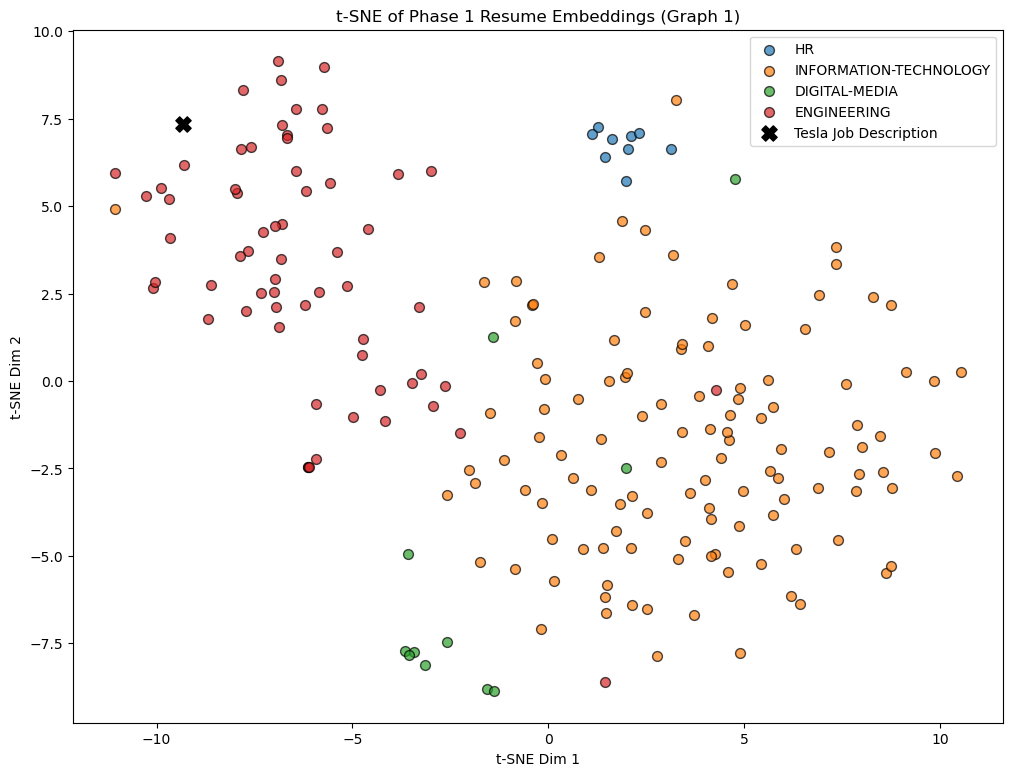

In [30]:
# Graphing resume embeddings with computed similarity
# https://medium.com/analytics-vidhya/visualising-embeddings-with-t-sne-b54bf6b635f

resume_embeddings = df_tech_match['Cleaned_str'].apply(lambda x: m_SBERT.encode(x))
resume_embeddings = np.vstack(resume_embeddings)
all_embeddings = np.vstack([resume_embeddings, tesla_job_embeddings])

# Perplexity is too high, so update it to a number between 5 and 30 based on neighbors
n_samples = all_embeddings.shape[0]
l_perplexity = min(30, max(2, math.floor(n_samples / 3)))

tsne = TSNE(random_state = 0, max_iter = 1000, metric = 'cosine', perplexity = l_perplexity)
tnse_fitted = tsne.fit_transform(all_embeddings)

df_tnse_fitted = pd.DataFrame()

# Get the category of each of the points
df_tnse_fitted['Category'] = df_tech_match['Category']
categories = df_tnse_fitted['Category'].astype('category')
color_codes = categories.cat.codes

df_tnse_fitted['X'] = tnse_fitted[:-1,0]
df_tnse_fitted['Y'] = tnse_fitted[:-1,1]

# Job description
x_job = tnse_fitted[-1, 0]
y_job = tnse_fitted[-1, 1]

# Plot everything
plt.figure(figsize=(12, 9))

# I had to use ChatGPT for this part because, honestly, I have no idea how to do this and couldn't find a way.
# I asked the TA if it was okay during a check-in, and she said it was okay.

# This part basically plots the points, and colors them based on what category they're in, 
# it then also creates a legend for the categories on the plot
unique_categories = df_tnse_fitted['Category'].unique()
colors = plt.cm.tab10.colors

# Loop through each category to plot them one by one
for idx, category in enumerate(unique_categories):
    subset = df_tnse_fitted[df_tnse_fitted['Category'] == category]
    plt.scatter(
        subset['X'], subset['Y'],
        color=colors[idx % len(colors)],
        edgecolors='black',
        label=category,
        s=50,
        alpha = 0.7
    )
# Till this part

# Plotting job position embeddings as a marker
plt.scatter(x_job, y_job, color='black', marker='X', s=120, label='Tesla Job Description', zorder=10)

# Axis labels and title
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.title("t-SNE of Phase 1 Resume Embeddings (Graph 1)")
plt.legend()
plt.show()

**t-SNE Visualization of Resume Embeddings and Job Description:** 
This graph is a visual representation of the flattened SBERT embeddings of the closest resumes in terms of similarity. In addition to the SBERT embeddings of the Job description (marked by an `X`). Additionally, similar to the previous graph, the position of the resumes is based on their embeddings; thus, the closer to the job description, means the two are semantically more similar.

**Analysis:** This t-SNE plot shows the embeddings of the resumes that remained after the hard criteria cleaning of Phase 1. These are all of the candidates who meet the baseline requirements for the position. Additionally, you may notice that the embeddings are still quite spread out; this is because we have not applied semantic filtering yet. However, in general, we can see that a significant portion of the resumes not in the relevant field have been removed from the selection process, thus leaving primarily IT and Engineering, which overlap quite well with the job position.

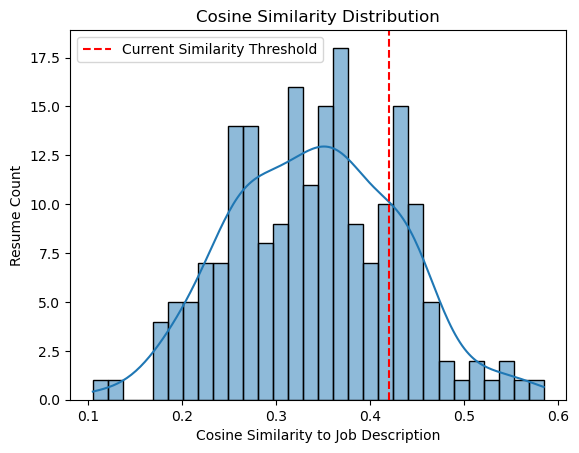

In [32]:
sns.histplot(df_tech_match["Computed_similarity"], bins=30, kde=True)
plt.axvline(0.42, color='red', linestyle='--', label='Current Similarity Threshold')
plt.xlabel("Cosine Similarity to Job Description")
plt.ylabel("Resume Count")
plt.title("Cosine Similarity Distribution")
plt.legend()
plt.show()

In [33]:
# If over a similarity threshold, add to a new dataframe
df_tech_cleaned = df_tech_match[df_tech_match['Computed_similarity'] >= 0.42].copy()
df_tech_cleaned.info()
df_tech_cleaned.head()

<class 'pandas.core.frame.DataFrame'>
Index: 42 entries, 222 to 1804
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   42 non-null     int64  
 1   Resume_str           42 non-null     object 
 2   Category             42 non-null     object 
 3   Cleaned_str          42 non-null     object 
 4   education_level      42 non-null     object 
 5   matching_degree      42 non-null     bool   
 6   Computed_similarity  42 non-null     float32
dtypes: bool(1), float32(1), int64(1), object(4)
memory usage: 2.2+ KB


,ID,Resume_str,Category,Cleaned_str,education_level,matching_degree,Computed_similarity
222,91635250,Christopher Townes Summa...,INFORMATION-TECHNOLOGY,christopher townes summary knowledgeable infor...,Unknown,True,0.445310
224,15651486,DIRECTOR OF INFORMATION TECHNOLOGY ...,INFORMATION-TECHNOLOGY,director of information technology career over...,Associate,True,0.432384
225,52246737,INFORMATION TECHNOLOGY PROVISIONING T...,INFORMATION-TECHNOLOGY,information technology provisioning technician...,Associate,True,0.440459
232,24913648,INFORMATION TECHNOLOGY SPECIALIST ...,INFORMATION-TECHNOLOGY,information technology specialist professional...,Bachelor,True,0.423039
248,19201175,INFORMATION TECHNOLOGY SPECIALIST ...,INFORMATION-TECHNOLOGY,information technology specialist summary rece...,High School,True,0.440902


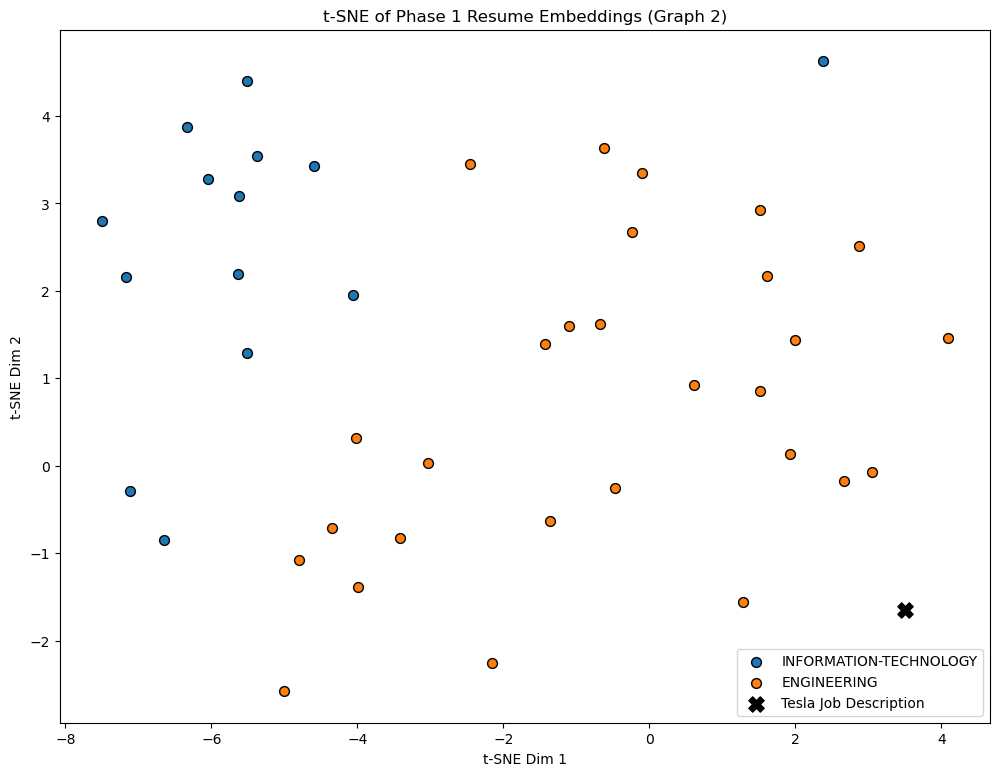

In [34]:
# Graphing resume embeddings with computed similarity
# https://medium.com/analytics-vidhya/visualising-embeddings-with-t-sne-b54bf6b635f

resume_embeddings = df_tech_cleaned['Cleaned_str'].apply(lambda x: m_SBERT.encode(x))
resume_embeddings = np.vstack(resume_embeddings)
all_embeddings = np.vstack([resume_embeddings, tesla_job_embeddings])

# Perplexity is too high, so update it to a number between 5 and 30 based on neighbors
n_samples = all_embeddings.shape[0]
l_perplexity = min(30, max(2, math.floor(n_samples / 3)))

tsne = TSNE(random_state = 0, max_iter = 1000, metric = 'cosine', perplexity = l_perplexity)
tnse_fitted = tsne.fit_transform(all_embeddings)

df_tnse_fitted = pd.DataFrame()

# Get Category for colors
df_tnse_fitted['Category'] = df_tech_cleaned['Category']
categories = df_tnse_fitted['Category'].astype('category')
color_codes = categories.cat.codes

df_tnse_fitted['X'] = tnse_fitted[:-1,0]
df_tnse_fitted['Y'] = tnse_fitted[:-1,1]

# Job description
x_job = tnse_fitted[-1, 0]
y_job = tnse_fitted[-1, 1]

# Plot everything
plt.figure(figsize=(12, 9))

# I had to use ChatGPT for this part because honestly, I have no idea how to do this and couldn't find a way
# I asked the TA if it was okay during a check-in, and she said it was okay.

# This part basically plots the points, and colors them based on what category they're in, 
# it then also creates a legend for the categories on the plot
unique_categories = df_tnse_fitted['Category'].unique()
colors = plt.cm.tab10.colors

# Loop through each category to plot them one by one
for idx, category in enumerate(unique_categories):
    subset = df_tnse_fitted[df_tnse_fitted['Category'] == category]
    plt.scatter(
        subset['X'], subset['Y'],
        color=colors[idx % len(colors)],
        edgecolors='black',
        label=category,
        s=50
    )
# Till this part

# Plotting job position embeddings as a marker
plt.scatter(x_job, y_job, color='black', marker='X', s=120, label='Tesla Job Description', zorder=10)

# Axis labels and title
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.title("t-SNE of Phase 1 Resume Embeddings (Graph 2)")
plt.legend()
plt.show()

**t-SNE Visualization of Resume Embeddings and Job Description:** 
This graph is a visual representation of the flattened SBERT embeddings of the closest resumes in terms of similarity. In addition to the SBERT embeddings of the Job description (marked by an `X`). Additionally, similar to the previous graph, the position of the resumes is based on their embeddings; thus, the closer to the job description, means the two are semantically more similar.

**Analysis:** This t-SNE plot shows the embeddings of the resumes that remained after the process of phase 1. We can see that the majority of the applicants who were initially accepted past the baseline requirements have now been removed, and the applicant pool has been simplified to those who have moderate to high similarity to the job description. Interestingly, a majority of the overlap in the original bucket between the 4 categories has mostly been removed, and now we see only two categories: IT and engineering.

## 2. Second Resume Cleaning Cycle

In [37]:
df_ideal.head()

,ID,Resume_str,Category,Cleaned_str,education_level
1695,82246962,TEST ENGINEERING Profile I a...,ENGINEERING,test engineering profile i am seeking the chal...,Associate
1802,12472574,QA ENGINEERING TEAM LEAD Care...,ENGINEERING,qa engineering team lead career overview eight...,Unknown


In [38]:
# calculate average embeddings of the IDEAL resumes
def average_embeddings(subset):
    avg_embeddings = subset['Cleaned_str'].apply(lambda x: m_SBERT.encode(x))
    matrix_embeddings = np.vstack(avg_embeddings)
    avg = np.mean(matrix_embeddings, axis = 0)
    return avg

ideal_embeddings = average_embeddings(df_ideal)

#print(ideal_embeddings)

In [39]:
def p2_compute_similarity(resume):
    resume_embeddings = m_SBERT.encode(resume)
    similarity = cosine_similarity([resume_embeddings], [ideal_embeddings])[0][0]
    return similarity

df_tech_cleaned['Phase2_computed_similarity'] = df_tech_cleaned['Cleaned_str'].apply(p2_compute_similarity)
df_tech_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42 entries, 222 to 1804
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          42 non-null     int64  
 1   Resume_str                  42 non-null     object 
 2   Category                    42 non-null     object 
 3   Cleaned_str                 42 non-null     object 
 4   education_level             42 non-null     object 
 5   matching_degree             42 non-null     bool   
 6   Computed_similarity         42 non-null     float32
 7   Phase2_computed_similarity  42 non-null     float32
dtypes: bool(1), float32(2), int64(1), object(4)
memory usage: 2.3+ KB


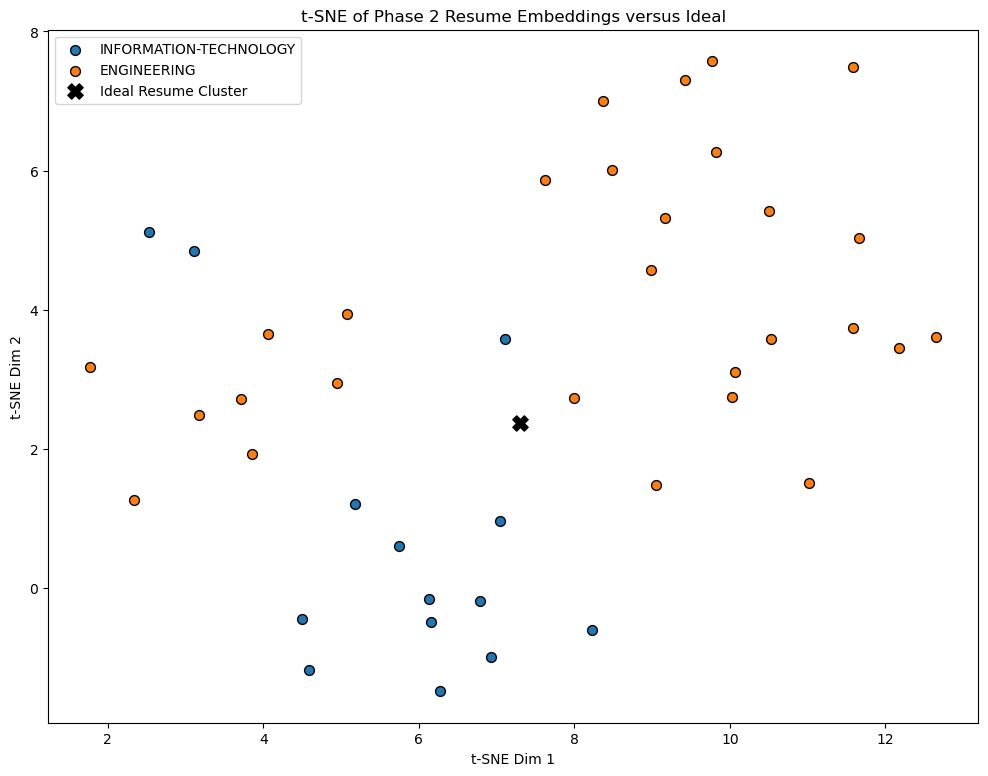

In [40]:
# Graphing resume embeddings with computed similarity
# https://medium.com/analytics-vidhya/visualising-embeddings-with-t-sne-b54bf6b635f

resume_embeddings = df_tech_cleaned['Cleaned_str'].apply(lambda x: m_SBERT.encode(x))
resume_embeddings = np.vstack(resume_embeddings)
all_embeddings = np.vstack([resume_embeddings, ideal_embeddings])

# Perplexity is too high, so update it to a number between 5 and 30 based on neighbors
n_samples = all_embeddings.shape[0]
l_perplexity = min(30, max(2, math.floor(n_samples / 3)))

tsne = TSNE(random_state = 0, max_iter = 1000, metric = 'cosine', perplexity = l_perplexity)
tnse_fitted = tsne.fit_transform(all_embeddings)

df_tnse_fitted = pd.DataFrame()

# Get Colors for plotting unique categories
df_tnse_fitted['Category'] = df_tech_cleaned['Category']
categories = df_tnse_fitted['Category'].astype('category')
color_codes = categories.cat.codes

df_tnse_fitted['X'] = tnse_fitted[:-1,0]
df_tnse_fitted['Y'] = tnse_fitted[:-1,1]

# Ideal resume embeddings
x_ideal = tnse_fitted[-1, 0]
y_ideal = tnse_fitted[-1, 1]

# Plot everything
plt.figure(figsize=(12, 9))

# I had to use ChatGPT for this part because honestly, I have no idea how to do this and couldn't find a way
# I asked the TA if it was okay during a check-in, and she said it was okay.

# This part plots the points and colors them based on what category they're in. 
# It then also creates a legend for the categories on the plot
unique_categories = df_tnse_fitted['Category'].unique()
colors = plt.cm.tab10.colors

# Loop through each category to plot them one by one
for idx, category in enumerate(unique_categories):
    subset = df_tnse_fitted[df_tnse_fitted['Category'] == category]
    plt.scatter(
        subset['X'], subset['Y'],
        color=colors[idx % len(colors)],
        edgecolors='black',
        label=category,
        s=50
    )
# Till this part

# Plotting job position embeddings as a marker
plt.scatter(x_ideal, y_ideal, color='black', marker='X', s=120, label='Ideal Resume Cluster', zorder=10)

# Axis labels and title
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.title("t-SNE of Phase 2 Resume Embeddings versus Ideal")
plt.legend()
plt.show()

**Analysis:** This t-SNE plot shows us the relative positions of the Ideal Resume Cluster and the remaining resume embeddings in 2D space. Interestingly, we can see that the Ideal Resume cluster is located more centrally within the plot, whereas the job description is located near the corners. This suggests that the Ideal Resume cluster shares more semantic overlap not only with the job description, but the remaining resumes as well. Therefore, we have effectively created a closely-knit group of relevant resumes.

Moreover, given the Ideal Resume cluster is roughly in the center, between both Engineering and IT embeddings, it suggests and corroborates the previous information that we found, that there can be a significant amount of semantic similarity between IT and Engineering resumes. It's important to note that the axes in the above plot are not of the same size as previous plots; while the embeddings are visually spread out, their semantic distances are quite small because of dimensionality reduction when plotting. Thus, these embeddings are extremely closely related to each other, especially when compared to previous plottings of the entire bucket.

## 3. Third Resume Cleaning Cycle & SVM Training

In [43]:
# Manually Label resumes as qualified or not
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

phase3_SBERT = SentenceTransformer('all-MiniLM-L6-v2')

df_manual = pd.read_csv("Manually-Labeled-Resumes.csv")
df_manual = df_manual.dropna(subset=['Manual_Label'])

# Extract features and labels
str_embedding = phase3_SBERT.encode(df_manual['Cleaned_str'].tolist())

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
education_encoded = encoder.fit_transform(df_manual[['education_level']])

X = np.hstack((str_embedding, education_encoded))
y = df_manual['Manual_Label'].astype(int).values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [44]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

svm_model = SVC(kernel='rbf', C=0.1, class_weight='balanced')
svm_model.fit(X_train, y_train)

scores = cross_val_score(svm_model, X_scaled, y, cv=5)
print("CV Accuracy Scores: ", scores)
print("Mean CV Accuracy:", scores.mean())

CV Accuracy Scores:  [0.77777778 1.         0.25       0.625      0.625     ]
Mean CV Accuracy: 0.6555555555555556


In [45]:
from sklearn.metrics import accuracy_score, classification_report
y_pred = svm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.7777777777777778
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.75      1.00      0.86         6

    accuracy                           0.78         9
   macro avg       0.88      0.67      0.68         9
weighted avg       0.83      0.78      0.74         9



Text(50.722222222222214, 0.5, 'Actual Label')

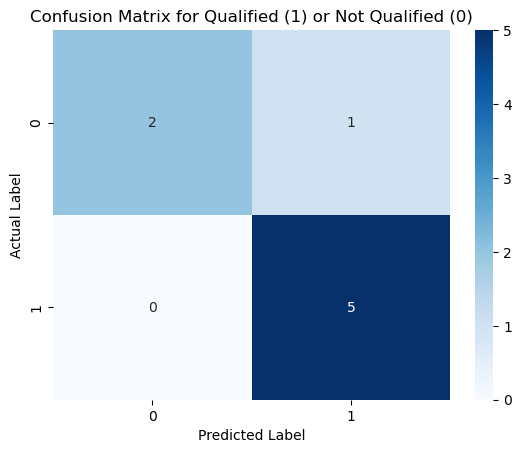

In [185]:
#Confusion matrix of results:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
conf = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
sns.heatmap(conf, annot = True, cmap = "Blues")
plt.title("Confusion Matrix for Qualified (1) or Not Qualified (0)")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")

**Process and Analysis:** Analysis of SVM model with manual labels: This SVM used the library sklearn from scikit and newly created manual labels based off of assigning resume in our narrowed dataset of 42 resumes as qualified (1) or not qualified (0). The main input feature this SVM uses to predict the qualifications of other resumes is education level. 

First, we use the results of resume embeddings, which converts resumes into usable numerical vector representations, and the results of one hot encoding, which converts the education level of applicants into a binary format where 1 is assigned to an education level if that is the applicants’ listed education level and 0 is assigned to the other education levels that are not the applicants’ current education level. 

The X label, which takes in input features of the education levels through one hot encoding and resume text converted into embeddings, is normalized using StandardScalar library, so our model and give accurate results. Then, the X label and the y label, which will be used to predicted whether a resume is qualified, are trained and tested with a 80:20 split, where 80% of the resumes are used for training and 20% of the resumes are used for testing.

When the model using Support Vector Classification (SVC) is ran, the Radial Basis Function (RBF) kernel is used to account for non-linear patterns in our data, the C parameter is assigned 0.1 penalization for misclassification to prevent over-fitting, and class weight is balanced to prevent bias in the model. Additionally, in order to confirm accurate measures for the classification model cross validation was performed five times for an average cross validation score of 0.6556 or 65.56%. This indicates there are some varying accuracy rates when the model is ran multiple times and compared, which may indicate some overfitting.

When the model is ran for prediction, the final accuracy value is 77.78%, which means that the model accurately predicted the qualifications of 77.78% of resumes. This is neither a high or low accuracy value, but is closer to higher accuracy value ranges of 80% to 90%. However, it is still lower than the accuracy value for the SVM model made by scratch, which suggests that that using linear regression for our model was preferred over radial basis function to give a higher accuracy score. Overfitting also could have caused some problems when testing with the entire dataset at the end. Additionally, the results of the heat map show that 5 of the 8 resumes tested in the dataset where predicted as qualified when actually qualified.


In [48]:
import numpy as np

class SVM:
    def __init__(self, learning_rate = 0.001, lambda_param=0.01, n_iters=1000):
        self.lr = learning_rate                 #Contols how fast the model updates
        self.lambda_param = lambda_param        #reguliazation strength to prevent overfitting
        self.n_iters = n_iters                 #Number of training loops
        self.weight = None                      #Model coefficients
        self.bias = None                        #Bias used to offset for decision bouindary 

    def fit(self, X, y):
        n_samples, n_features = X.shape         #number of samples(rows), features(columns)

        y_ = np.where(y <= 0, -1, 1)            #convert y to either -1 or 1
        self.weight = np.zeros(n_features)      #initilaize to 0
        self.bias = 0                           #initilaize to 0

        #training loop
        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.weight) - self.bias) >= 1 #checks to current sample is correclty classified
                if condition: 
                    self.weight -= self.lr * (2 * self.lambda_param * self.weight) #if correct onlt regulize
                else: 
                    self.weight -= self.lr * (2 * self.lambda_param * self.weight - np.dot(x_i, y_[idx])) #if incorrected put both gradient and regulize
                    self.bias -=  self.lr * y_[idx]

    def predict(self, X):                             #used to preficted if qualied or not qualified 
        approx = np.dot(X, self.weight) - self.bias 
        return np.sign(approx)

    def decision_function(self, X):
        return np.dot(X, self.weight) - self.bias    #finally classifies if it goes with -1 or 1 group

In [49]:
from sklearn.metrics import accuracy_score 

y_train_custom = np.where(y_train == 0, -1, 1)
svm = SVM(learning_rate=0.01, lambda_param=0.01, n_iters=5000)
svm.fit(X_train, y_train_custom)

y_pred_custom = svm.predict(X_test)
y_pred_custom = np.where(y_pred_custom == -1, 0, 1)

accuracy_custom = accuracy_score(y_test, y_pred_custom)
report_custom = classification_report(y_test, y_pred_custom)

print(f"Accuracy: {accuracy_custom * 100:.2f}%")
print("Classification Report:")
print(report_custom)

Accuracy: 88.89%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.86      1.00      0.92         6

    accuracy                           0.89         9
   macro avg       0.93      0.83      0.86         9
weighted avg       0.90      0.89      0.88         9



After making our model and manually labeling we trained our model to be able to recognize a qualified vs nonqualified depending the job description's ideal resume. When comparing the manual vs SVM classification for the resumes we concluded that our model's training accuracy was 88.89%   

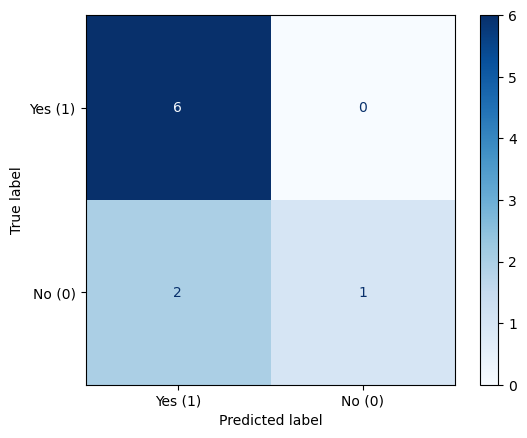

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf = confusion_matrix(y_test, y_pred, labels=[1, 0])

disp = ConfusionMatrixDisplay(conf, display_labels=['Yes (1)', 'No (0)'])
disp.plot(cmap=plt.cm.Blues)

**Analysis:** Using the predicted classicifcation from the training model and the human labeling gathered through our groups humanisitic approach to classify we can note that we labeled 25 resumes as being qualifed and 13 as being unqualifed manually. On the contraty the model training came out with 32 resumes being qualified and 6 being unqualified. With the confusions matrix taking into account it's own precictions with the 9 resumes tested we got 6 as being correctlyed labeled and qualified, 1 as being correctly predicted as not qualified and, opinions.